# Example Notebook for Correcting and loading FastCCD Images

This example reads data from the FastCCD and corrects and rotates the images. Included are some
example of widgets to interact with the data

## Getting Started

Load the ``databroker`` moudle, ``csxtools`` and various other dependencies

In [1]:
import numpy as np
from databroker import DataBroker, get_table, get_images
from csxtools.utils import get_fastccd_images, get_images_to_4D
from csxtools.ipynb import image_stack_to_movie, show_image_stack
%matplotlib notebook
from matplotlib import pyplot as plt
from filestore.handlers import HandlerBase
import h5py 

In [2]:
class AreaDetectorHDF5TimestampHandler(HandlerBase):
    """
    Handler for data stored in one Dataset of an HDF5 file.
    Parameters
    ----------
    filename : string
        path to HDF5 file
    key : string
        key of the single HDF5 Dataset used by this Handler
    frame_per_point : integer, optional
        number of frames to return as one datum, default 1
    """
    specs = {'AD_HDF5_TS'} | HandlerBase.specs
    
    def __init__(self, filename, frame_per_point=1):
        self._fpp = frame_per_point
        self._filename = filename
        self._key = '/entry/instrument/NDAttributes/NDArrayTimeStamp'
        self._file = None
        self._dataset = None
        self.open()

    def __call__(self, point_number):
        # Don't read out the dataset until it is requested for the first time.
        if not self._dataset:
            self._dataset = self._file[self._key]
        start, stop = point_number * self._fpp, (point_number + 1) * self._fpp
        rtn = self._dataset[start:stop].squeeze()
        rtn = rtn.reshape(1,1, len(rtn))
        return rtn
    
    def open(self):
        if self._file:
            return
        self._file = h5py.File(self._filename, 'r')

    def close(self):
        super(AreaDetectorHDF5TimestampHandler, self).close()
        self._file.close()
        self._file = None
    

Set the logger level to info to see logging output, if required!

In [3]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Get the data headers from the DataBroker!

In [4]:
bgnd = DataBroker['ce5042b7-00ae-49ca-9b11-b10c5661aaaa'] #[52440]

INFO:databroker.databroker:Interpreting key = ce5042b7-00ae-49ca-9b11-b10c5661aaaa as a str


## Get the timestamps

In [5]:
img = get_images(bgnd, 'fccd_image_lightfield', handler_override=AreaDetectorHDF5TimestampHandler)

In [6]:
timestamps = np.array(img[0]).ravel()

<IPython.core.display.Javascript object>


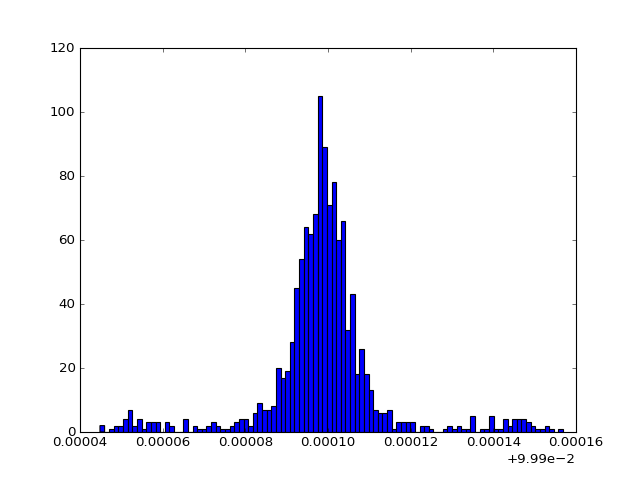

In [7]:
diff = np.diff(timestamps)
fig, axes = plt.subplots(1)
n = axes.hist(diff, bins=100)

In [8]:
import csxtools
csxtools.__version__

'0.1.5+1.gab5ccba'

In [9]:
import filestore
filestore.__version__

'0.2.2+17.g3a6f637'

In [10]:
import databroker
databroker.__version__

'0.3.2+6.g972ef05'